# Análisis de datos no estructurados: Análisis de Imágenes

### Autor: Felipe David Navarro Pecci

## Descripción:

En esta práctica se va a desarrollar un clasificador de imágenes para detectar si en dichas imágenes las personas están llevando mascarilla o no.

Para ello se va trabajar con la API de detección de objetos de Tensorflow

Dado que los modelos entrenados, los checkpoints y las imágenes pesan demasiado para ser subidos a Github, se adjuntan los siguientes archivos:

+ Este notebook explicando los pasos realizados y mostrando los resultados obtenidos
+ El fichero de configuración de la red convolucional y el entrenamiento "pipeline.config"
+ El fichero para lanzar el entrenamiento y la validación "model_main_tf2.py"

Si hubiera cualquier problema con alguno de los ficheros o se quiere hacer uso del modelo ya entrenado, ponte en contacto conmigo para obtener un link de descarga


### Setup

En primer lugar, hay que preparar el entorno de trabajo con las librerías y configuración adecuados.

Para ello, se sigue esta guía:

https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/install.html#set-env

NOTA: Si se trabaja en una máquina con GPU(s) es necesario tener instalado CUDA

+ CUDA Toolkit v10.1
+ CuDNN 7.6.5

En este caso se ha escogido trabajar en un equipo en local, en lugar de utilizar Google Colab. 

El equipo dispone de una GPU Nvidia GTX960M con 2GB de memoria


### Import de paquetes y librerías

In [1]:
## General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import datetime

In [3]:
## Limpieza de datos
import io
import os
import re
import argparse
import math
import random
import glob
import time

import xml.etree.ElementTree as ET

from object_detection.utils import dataset_util, label_map_util
from object_detection.utils import visualization_utils as viz_utils
from collections import namedtuple
from shutil import copyfile

In [16]:
## Trabajo con imágenes

import tensorflow as tf
import cv2
from PIL import Image

## Carga y limpieza de datos

Se va a trabajar con el siguiente dataset, obtenido de Kaggle: https://makeml.app/datasets/mask

Este dataset contiene 853 imágenes, pertenecientes a 3 clases:

+ Con mascarilla
+ Sin mascarilla
+ Con mascarilla llevada incorrectamente


Las imágenes vienen en formato PASCAL VOC. Cada imagen está por tanto definida por la imagen en sí y un fichero de anotaciones en formato xml que define las propiedades de dicha imagen.

Antes de empezar a separar las imágenes en test y training, vamos a ver qué pinta tienen estas imágenes

In [4]:
dic = {"image": [],"Dimensions": []} # Diccionario donde guardo mis datos
for i in range(1,30): # 853
    dic[f'Object {i}']=[]
print("Generating data in CSV format....")

for file in os.listdir("./images/full"):
    if file[-3:] == "xml":
        row = []
        xml = ET.parse("./images/full/"+file) 
        root = xml.getroot() # Apunto al nodo raíz
        img = root[1].text   # Nombre de la imagen
        row.append(img)
        h,w = root[2][0].text,root[2][1].text # Dimensiones: alto, ancho
        row.append([h,w]) 

        for i in range(4,len(root)): # Extraigo los tags y la posición de cada uno de los objetos contenidos en la imagen
            temp = []
            temp.append(root[i][0].text) # Extraigo el label
            for point in root[i][5]:     # Extraigo los límites de la "caja" que me delimita el objeto
                temp.append(point.text)
            row.append(temp)
        for i in range(len(row),32): # Para que mi dataframe contenga ceros en los elementos vacíos -- Máximo 30 objetos por imagen
            row.append(0)
        for i,each in enumerate(dic):
            dic[each].append(row[i])
df = pd.DataFrame(dic)

Generating data in CSV format....


In [5]:
# Compruebo que mi dataset se ha creado correctamente
df.head()

,image,Dimensions,Object 1,Object 2,Object 3,Object 4,Object 5,Object 6,Object 7,Object 8,...,Object 20,Object 21,Object 22,Object 23,Object 24,Object 25,Object 26,Object 27,Object 28,Object 29
0,maksssksksss0.png,"[512, 366]","[without_mask, 79, 105, 109, 142]","[with_mask, 185, 100, 226, 144]","[without_mask, 325, 90, 360, 141]",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,maksssksksss1.png,"[400, 156]","[with_mask, 321, 34, 354, 69]","[with_mask, 224, 38, 261, 73]","[with_mask, 299, 58, 315, 81]","[with_mask, 143, 74, 174, 115]","[with_mask, 74, 69, 95, 99]","[with_mask, 191, 67, 221, 93]","[with_mask, 21, 73, 44, 93]","[with_mask, 369, 70, 398, 99]",...,0,0,0,0,0,0,0,0,0,0
2,maksssksksss10.png,"[301, 400]","[with_mask, 98, 267, 194, 383]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,maksssksksss100.png,"[400, 226]","[with_mask, 189, 30, 245, 88]","[with_mask, 387, 54, 400, 75]","[with_mask, 118, 87, 163, 126]",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,maksssksksss101.png,"[301, 400]","[with_mask, 48, 294, 164, 400]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# Sólo pinta el recuadro de el primer objeto de la imagen
def draw_boxes(image_name):
    selected_value = df[df.image == image_name]
    img = cv2.imread('images/full/{}'.format(image_name))
    for index, row in selected_value.iterrows():
        img = cv2.rectangle(img, (int(row['Object 1'][1]), int(row['Object 1'][2])), (int(row['Object 1'][3]), int(row['Object 1'][4])), (0, 255, 0), 3)
    return img

In [7]:
img_name= "maksssksksss109.png"

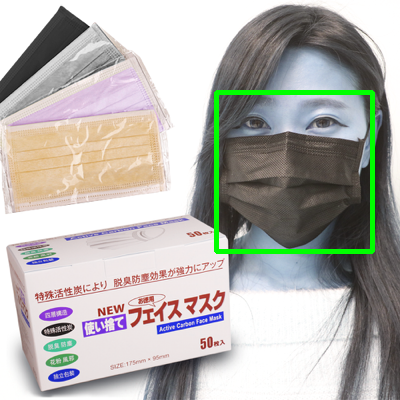

In [8]:
Image.fromarray(draw_boxes(img_name))

Cabe señalar que hay algunas imágenes que contienen más de una persona y por tanto hay varios objetos definidos en el xml de esas imágenes.

Las imágenes ya vienen anotadas, por lo que no es necesario hacer dicha anotación a mano. 
Si fuera necesario, se puede utilizar la librería labelImg (https://github.com/tzutalin/labelImg#usage), que proporciona un GUI para anotar las imágenes y permite guardar las anotaciones en formato PASCAL VOC o YOLO.

El siguiente paso es separar las imágenes junto con sus xmls en un conjunto de entrenamiento y un conjunto de test. (90/10)



In [12]:
ratio = 0.1  ## Ratio de imágenes de test

img_source = r"C:\Users\fdnav\mbd_image_facemask\Tensorflow\workspace\training\images\full"
img_dest = r"C:\Users\fdnav\mbd_image_facemask\Tensorflow\workspace\training\images"


In [13]:
def iterate_dir(source, dest, ratio, copy_xml):
    source = source.replace('\\', '/')  # Carpeta de origen de las imágenes y las anotaciones
    dest = dest.replace('\\', '/') # Carpeta de destino de las imágenes
    train_dir = os.path.join(dest, 'train') # Carpeta que contendrá los datos de entrenamiento
    test_dir = os.path.join(dest, 'test') # Carpeta que contendrá los datos de test

    # Crear carpetas de test y entrenamiento, si no existen ya
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)

    images = [f for f in os.listdir(source)
              if re.search(r'([a-zA-Z0-9\s_\\.\-\(\):])+(.jpg|.jpeg|.png)$', f)]

    num_images = len(images)
    num_test_images = math.ceil(ratio*num_images) # Defino cuántas imágenes de test me quedo, en función del ratio definido anteriormente

    for i in range(num_test_images):
        idx = random.randint(0, len(images)-1) # Tomo una imagen de forma aleatoria para mi conjunto de test
        filename = images[idx]
        copyfile(os.path.join(source, filename),  # Copio esa imagen a la carpeta de test
                 os.path.join(test_dir, filename))
        if copy_xml:
            xml_filename = os.path.splitext(filename)[0]+'.xml' # Copio el xml asociado a esa imagen a la carpeta de test
            copyfile(os.path.join(source, xml_filename),
                     os.path.join(test_dir,xml_filename))
        images.remove(images[idx])

    for filename in images:                         # Copio el resto de imágenes a la carpeta de entrenamiento
        copyfile(os.path.join(source, filename),
                 os.path.join(train_dir, filename))
        if copy_xml:
            xml_filename = os.path.splitext(filename)[0]+'.xml'
            copyfile(os.path.join(source, xml_filename),
                     os.path.join(train_dir, xml_filename))

In [14]:
iterate_dir(img_source,img_dest,ratio,True)

Compruebo que mis imágenes y mis xmls se han copiado correctamente antes de borrar las imágenes del directorio original

In [18]:
train_dir = os.path.join(img_dest, "train")
train_dir = train_dir.replace('\\', '/')
test_dir = os.path.join(img_dest, "test")
test_dir = test_dir.replace('\\', '/')

n_train = len(os.listdir(train_dir))
n_test = len(os.listdir(test_dir))

print(f"Hay {n_train} archivos en la carpeta train y {n_test} archivos en la carpeta test. {n_train + n_test} archivos en total")

Hay 1534 archivos en la carpeta train y 172 archivos en la carpeta test. 1706 archivos en total


**NOTA**: Se sigue la estructura de carpetas sugerida por Tensorflow

In [ ]:
"""
TensorFlow/
├─ addons/ (Optional)
│  └─ labelImg/
├─ models/
│  ├─ community/
│  ├─ official/
│  ├─ orbit/
│  ├─ research/
│  └─ ...
└─ workspace/
   └─ training/
       ├─ annotations/
       ├─ exported-models/
        ├─ images/
         │  ├─ test/
         │  └─ train/
       ├─ models/
       ├─ pre-trained-models/
       └─ README.md
"""

## Crear Label Map

Creamos un label map, que mapea los labels utilizados a un valor entero. (class id => class name)

Este fichero se guarda en la carpeta annotations y tiene extensión .pbtxt


In [ ]:
"""item {
    id: 1
    name: 'without_mask'
}

item {
    id: 2
    name: 'with_mask'
}

item {
    id: 
    name: 'mask_weared_incorrect'
}"""

## Generar TFrecords a partir de las imágenes y los xmls

La API de detección de objetos de Tensorflow utiliza TFRecord como formato de entrada. Además del label map hay que proporcionar la localización de los archivos de entrenamiento y validación (ya en formato tf_records)

In [26]:
XML_DIR_TR = r"C:\Users\fdnav\mbd_image_facemask\Tensorflow\workspace\training\images\train" # Ruta a la carpeta donde están los ficheros xml de training
XML_DIR_TEST = r"C:\Users\fdnav\mbd_image_facemask\Tensorflow\workspace\training\images\test" # Ruta a la carpeta donde están los ficheros xml de test
LABELS_PATH = r"C:\Users\fdnav\mbd_image_facemask\Tensorflow\workspace\training\annotations\label_map.pbtxt" # Ruta a la carpeta que contiene el fichero con el label map (.pbtxt)
OUTPUT_PATH_TR = r"C:\Users\fdnav\mbd_image_facemask\Tensorflow\workspace\training\annotations\train.record" # Ruta donde quiero guardar mis ficheros .record de training
OUTPUT_PATH_TEST = r"C:\Users\fdnav\mbd_image_facemask\Tensorflow\workspace\training\annotations\test.record"# Ruta donde quiero guardar mis ficheros .record de test
IMAGE_DIR_TR =  r"C:\Users\fdnav\mbd_image_facemask\Tensorflow\workspace\training\images\train" # Ruta a la carpeta donde tengo mis imágenes de training
IMAGE_DIR_TEST = r"C:\Users\fdnav\mbd_image_facemask\Tensorflow\workspace\training\images\test" # Ruta a la carpeta donde tengo mis imágenes de test

In [27]:
label_map = label_map_util.load_labelmap(LABELS_PATH)
label_map_dict = label_map_util.get_label_map_dict(label_map)

In [36]:
# Defino una función para iterar sobre los .xml y combinarlos en un df de Pandas

def xml_to_csv(path):

    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[5][0].text),
                     int(member[5][1].text),
                     int(member[5][2].text),
                     int(member[5][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [37]:
# Mapear label del xml según el label map definido
def class_text_to_int(row_label):
    return label_map_dict[row_label]

def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]

In [38]:
def create_tf_example(group, path):
    with tf.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_png = fid.read()
    encoded_png_io = io.BytesIO(encoded_png)
    image = Image.open(encoded_png_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'png'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    # Se normalizan las "cajas" que delimitan los objetos
    for index, row in group.object.iterrows(): 
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class']))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_png),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example

**Training**

In [5]:
import tensorflow.compat.v1 as tf

In [39]:
writer = tf.python_io.TFRecordWriter(OUTPUT_PATH_TR)
path = os.path.join(IMAGE_DIR_TR)
examples = xml_to_csv(XML_DIR_TR)
grouped = split(examples, 'filename')

In [40]:
for group in grouped:
    tf_example = create_tf_example(group, path)
    writer.write(tf_example.SerializeToString())
writer.close()

**Test**

In [41]:
writer = tf.python_io.TFRecordWriter(OUTPUT_PATH_TEST)
path = os.path.join(IMAGE_DIR_TEST)
examples = xml_to_csv(XML_DIR_TEST)
grouped = split(examples, 'filename')

In [42]:
for group in grouped:
    tf_example = create_tf_example(group, path)
    writer.write(tf_example.SerializeToString())
writer.close()

## Descarga de modelo pre-entrenado

Se va a utilizar transfer learning, pues entrenar un modelo de detección de objetos desde 0 es muy costoso y no se dispone de un número muy elevado de imágenes.

Para ello se descarga el modelo desde "Tensorflow 2 Detection Model Zoo"  
(https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md)

Estos modelos están entrenados con el dataset COCO 2017

En primera instancia se iba a partir del modelo SSD ResNet50 V1 FPN 640x640, pero este resultó ser demasiado grande/pesado de entrenar para el hardware disponible. Por ello se optó por un modelo más ligero: SSD MOBILENET V2 FPNLITE 320X320

Para trabajar con uno de estos modelos hay que descargarlos desde el Tensorflow Model Zoo y descomprimir el .tar.gz que se descarga.

Source: https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md

Los contenidos se guardan en la carpeta pre-trained-models


In [ ]:
"""
training/
├─ ...
├─ pre-trained-models/
│  └─ ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/
│     ├─ checkpoint/
│     ├─ saved_model/
│     └─ pipeline.config
└─ ...
"""

## Configuración del entrenamiento


La API de detección de objetos de tensorflow utiliza un fichero protobuf para configurar los procesos de entrenamiento y evaluación.

Este fichero de configuración consta de 5 partes principales:

+ model : Define qué tipo de modelo se va a entrenar
+ train_config : Define qué parámetros se van a usar para entrenar el modelo
    - Inicialización de los parámetros del modelo
    - Preprocesamiento de las imágenes de entrada
    - Parámetros del SGD (Stochastic Gradient Descent)
    - Opcional: data_augmentation_options
+ eval_config: Define qué conjunto de métricas se va a emplear para la evaluación del modelo
+ train_input_config: Define qué dataset se va a usar para entrenar el modelo
+ eval_input_config: Define qué dataset se va a utilizar para evaluar el modelo.

Para configurar el pipeline de entrenamiento, se crea la carpeta "my_ssd_mobilenet_v2" en /training/models y se copia el fichero pipeline.config que viene con el modelo que se acaba de descargar. 

Este fichero contiene los campos model, train_config, eval_config, train_input_config y eval_config descritos anteriormente

In [1]:
"""
training/
├─ ...
├─ models/
│  └─ my_ssd_mobilenet_v2/
│     └─ pipeline.config
└─ ...
"""

'\ntraining/\n├─ ...\n├─ models/\n│  └─ my_ssd_mobilenet_v2/\n│     └─ pipeline.config\n└─ ...\n'

A continuación hay que adaptar dicho fichero a nuestro caso de uso:

In [ ]:
"""
model {
  ssd {
    num_classes: 3 ### Numero de clases
    image_resizer {
      fixed_shape_resizer {  ### Normalización del tamaño de la imagen
        height: 320
        width: 320
      }
    }
    feature_extractor {
      type: "ssd_mobilenet_v2_fpn_keras"
      depth_multiplier: 1.0
      min_depth: 16
      conv_hyperparams {
        regularizer {
          l2_regularizer {
            weight: 3.9999998989515007e-05
          }
        }
        initializer {
          random_normal_initializer {
            mean: 0.0
            stddev: 0.009999999776482582
          }
        }
        activation: RELU_6
        batch_norm {
          decay: 0.996999979019165
          scale: true
          epsilon: 0.0010000000474974513
        }
      }
      use_depthwise: true
      override_base_feature_extractor_hyperparams: true
      fpn {
        min_level: 3
        max_level: 7
        additional_layer_depth: 128
      }
    }
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
        use_matmul_gather: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    box_predictor {
      weight_shared_convolutional_box_predictor {
        conv_hyperparams {
          regularizer {
            l2_regularizer {
              weight: 3.9999998989515007e-05
            }
          }
          initializer {
            random_normal_initializer {
              mean: 0.0
              stddev: 0.009999999776482582
            }
          }
          activation: RELU_6
          batch_norm {
            decay: 0.996999979019165
            scale: true
            epsilon: 0.0010000000474974513
          }
        }
        depth: 128
        num_layers_before_predictor: 4
        kernel_size: 3
        class_prediction_bias_init: -4.599999904632568
        share_prediction_tower: true
        use_depthwise: true
      }
    }
    anchor_generator {
      multiscale_anchor_generator {
        min_level: 3
        max_level: 7
        anchor_scale: 4.0
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect_ratios: 0.5
        scales_per_octave: 2
      }
    }
    post_processing {
      batch_non_max_suppression {
        score_threshold: 9.99999993922529e-09
        iou_threshold: 0.6000000238418579
        max_detections_per_class: 100
        max_total_detections: 100
        use_static_shapes: false
      }
      score_converter: SIGMOID
    }
    normalize_loss_by_num_matches: true
    loss {
      localization_loss {
        weighted_smooth_l1 {
        }
      }
      classification_loss {
        weighted_sigmoid_focal {
          gamma: 2.0
          alpha: 0.25
        }
      }
      classification_weight: 1.0
      localization_weight: 1.0
    }
    encode_background_as_zeros: true
    normalize_loc_loss_by_codesize: true
    inplace_batchnorm_update: true
    freeze_batchnorm: false
  }
}
train_config {
  batch_size: 4    #### CONFIG BATCH SIZE
  data_augmentation_options {       ### Opciones de data augmentation -- En este caso giro horizontal y recorte aleatorios
    random_horizontal_flip {
    }
  }
  data_augmentation_options {
    random_crop_image {
      min_object_covered: 0.0
      min_aspect_ratio: 0.75
      max_aspect_ratio: 3.0
      min_area: 0.75
      max_area: 1.0
      overlap_thresh: 0.0
    }
  }
  sync_replicas: true
  optimizer {
    momentum_optimizer {
      learning_rate {
        cosine_decay_learning_rate {
          learning_rate_base: 0.07999999821186066
          total_steps: 50000
          warmup_learning_rate: 0.026666000485420227
          warmup_steps: 1000
        }
      }
      momentum_optimizer_value: 0.8999999761581421
    }
    use_moving_average: false
  }	
  fine_tune_checkpoint: ".\\pre-trained-models\\ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8\\checkpoint\\ckpt-0"   ### Elegir el checkpoint de partida para el entrenamiento
  num_steps: 50000
  startup_delay_steps: 0.0
  replicas_to_aggregate: 8
  max_number_of_boxes: 100
  unpad_groundtruth_tensors: false
  fine_tune_checkpoint_type: "detection"              ### Elegir detection/classification 
  fine_tune_checkpoint_version: V2    
}
train_input_reader {
  label_map_path: ".\\annotations\\label_map.pbtxt"   ### Path al label map
  tf_record_input_reader {
    input_path: ".\\annotations\\train.record"        ### Path a los tfrecords de entrenamiento
  }
}
eval_config {
  metrics_set: "coco_detection_metrics"                ### Métricas a utilizar en la evaluación
  use_moving_averages: false
}
eval_input_reader {
  label_map_path: ".\\annotations\\label_map.pbtxt"    ### Path al label map
  shuffle: false
  num_epochs: 3
  tf_record_input_reader {
    input_path: ".\\annotations\\test.record"          ### Path a los tfrecords de test
  }
}

"""

#### Tensorboard

Antes de empezar el entrenamiento, se configura tensorboard para poder monitorizarlo

In [6]:
%load_ext tensorboard

In [5]:
# %reload_ext tensorboard

In [7]:
tensorboard --logdir=models\\my_ssd_mobilenet_v2 --port=8008

## Entrenamiento

Comprobación de número de GPUs disponibles

In [7]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
tf.config.experimental.list_logical_devices('GPU')

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [26]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num GPUs Available: ", len(tf.config.experimental.list_logical_devices('GPU')))

Num GPUs Available:  1
Num GPUs Available:  1


El equipo donde se va a realizar el entrenamiento cuenta con una GPU (NVIDIA GTX960M - 2Gb) 

**Lanzar entrenamiento**

In [ ]:
# !python model_main_tf2.py --model_dir=models/my_ssd_resnet50_v1_fpn --pipeline_config_path=models/my_ssd_resnet50_v1_fpn/pipeline.config

In [7]:
!python model_main_tf2.py --model_dir=models/my_ssd_mobilenet_v2 --pipeline_config_path=models/my_ssd_mobilenet_v2/pipeline.config

Finalmente se ha detenido el entrenamiento tras 14000 pasos, los cuales han requerido unas 3h de ejecución.

Se puede observar como el total_loss desciende rápidamente en los primeros 2000 pasos, para luego continuar descendiendo más lentamente. Probablemente podría entrenarse durante mucho más tiempo, pero en este caso el hardware disponible ha supuesto una limitación. El entrenamiento del modelo ha requerido más de 10GB libres en disco.

Cabe señalar que el learning rate cae significativamente, por lo que entrenar durante mucho más tiempo tendría un beneficio cada vez menor. Si se quiere mejorar el modelo lo más apropiado sería conseguir muchas más imágenes.

## Validación

Si bien lo útil sería correr la validación en paralelo al entrenamiento para detectar el sobreaprendizaje, esto no ha sido posible por limitaciones en el hardware

Es por ello que en Tensorboard se aprecia únicamente un punto de evaluación, correspondiente al último checkpoint de entrenamiento del modelo

In [ ]:
!python model_main_tf2.py --alsologtostderr --model_dir=models/my_ssd_mobilenet_v2 --pipeline_config_path=models/my_ssd_mobilenet_v2/pipeline.config --checkpoint_dir=models/my_ssd_mobilenet_v2

En cuanto a las métricas de validación, conviene aclarar el significado de las mismas:

+ IoU: Intersection over Union => Representa el área de la intersección dividida entre el área de la unión de una caja predecida frente a la caja real
+ mAP: Precisión media absoluta (Positivos reales / (Falsos positivos + Positivos reales))
+ Recall: (Positivos reales / (Falsos negativos + Positivos reales))

Se da el mAP para diferentes valores de IoU.

Si se escogen dos de estas métricas:

DetectionBoxes_Recall/AR@100 => Recall dividido entre el número máximo de detecciones en la imagen, en este caso 100:  **0,8401**

DetectionBoxes_Precision/mAP (small): **0.6667**

Si bien a priori estas métricas parecen buenas, parece que algo no cuadra con las mismas, ya que los resultados al observar las predicciones sobre imágenes no son especialmente buenos


    


En la pestaña images de tensorboard se puede ver la clasificación que hace el modelo en la clasificación frente a los labels reales.

+ El modelo detecta bien si una persona lleva o no mascarilla en imágenes con un solo objeto
+ En imágenes con varios objetos al modelo le cuesta detectar todos los objetos
+ Cuando se mezclan personas con y sin mascarilla el modelo tiende a etiquetar estos casos como con mascarilla

Se concluye por tanto que el modelo probablemente necesite más imágenes para el entrenamiento y más épocas de entrenamiento.

Se muestran algunas de esas imágenes por si hubiera algún problema con tensorboard

A la izquierda la salida del modelo y a la derecha la imagen real con sus labels

![eval1](eval_results/eval1.png)

![eval2](eval_results/eval2.png)

![eval3](eval_results/eval3.png)

![eval4](eval_results/eval4.png)

![eval5](eval_results/eval5.png)

![eval1](eval_results/eval6.png)

### Exportar modelo

A continuación se exporta el modelo

In [9]:
!python .\exporter_main_v2.py --input_type image_tensor --pipeline_config_path .\models\my_ssd_mobilenet_v2\pipeline.config --trained_checkpoint_dir .\models\my_ssd_mobilenet_v2\ --output_directory .\exported-models\model_mobilenetv2_mbd

### Plot de predicciones del modelo

**Cargar modelo**

In [14]:
PATH_TO_MODEL_DIR = ".\\exported-models"

PATH_TO_SAVED_MODEL = PATH_TO_MODEL_DIR + "\\model_mobilenetv2_mbd\\saved_model"

In [17]:
print('Cargando modelo...', end='')
start_time = time.time()

# Cargar modelo y construir función de detección
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Hecho! Duración {} segundos'.format(elapsed_time))

Cargando modelo...Hecho! Duración 44.8052442073822 segundos


**Cargar label map**

In [21]:
LABELS_PATH = ".\\annotations\\label_map.pbtxt"

In [22]:
category_index = label_map_util.create_category_index_from_labelmap(LABELS_PATH,
                                                                    use_display_name=True)

**Cargar imagen, pasarla por el modelo y visualizar su salida**

In [23]:
warnings.filterwarnings('ignore') ## Eliminar warnings de matplotlib

In [24]:
def load_image_into_numpy_array(path):
    return np.array(Image.open(path))

In [37]:
img_prueba = ".\\img_prueba"

IMAGE_PATHS = os.listdir(img_prueba)

Probamos ahora a detectar las caras y clasificar con imágenes que no estaban ni en el conjunto de test ni el de entrenamiento

Corriendo modelo para img1.jpg... Done
Corriendo modelo para img2.jpg... Done
Corriendo modelo para img3.jpg... Done
Corriendo modelo para img4.jpg... Done
Corriendo modelo para img5.jpg... Done
Corriendo modelo para img6.jpg... Done
Corriendo modelo para img7.jpg... Done


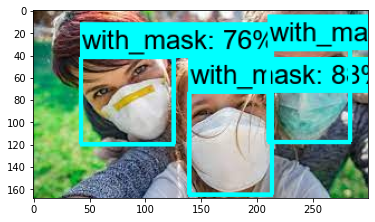

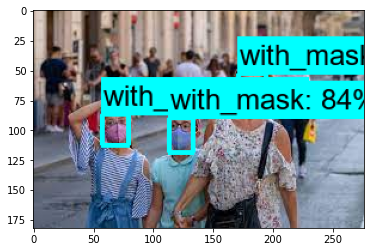

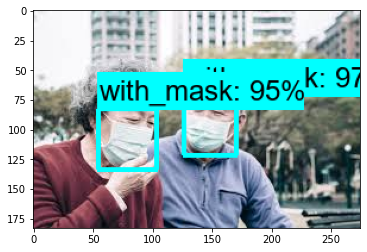

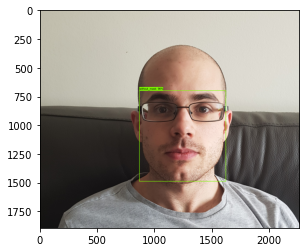

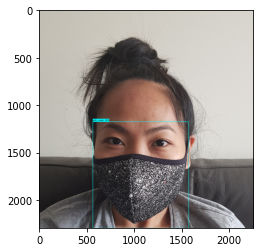

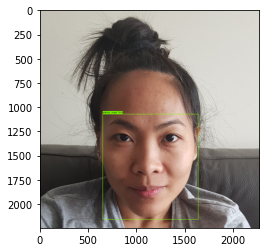

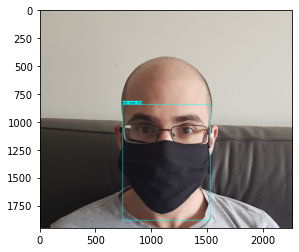

In [38]:
%matplotlib inline
for image_path in IMAGE_PATHS:

    print('Corriendo modelo para {}... '.format(image_path), end='')
    
    image_path = img_prueba + "\\" + image_path

    image_np = load_image_into_numpy_array(image_path)

    # Things to try:
    # Flip horizontally
    # image_np = np.fliplr(image_np).copy()

    # Convert image to grayscale
    # image_np = np.tile(
    #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    # input_tensor = np.expand_dims(image_np, 0)
    detections = detect_fn(input_tensor)
    
    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.30,
          agnostic_mode=False)

    plt.figure()
    plt.imshow(image_np_with_detections)
    print('Done')
plt.show()

El modelo ha conseguido clasificar todas las imagenes correctamente, aunque se trata de casos no especialmente complejos

### Conclusiones

Los requisitos de Hardware para entrenar un modelo de detección y clasificación de modelos son muy altos, tanto a nivel de GPU como de almacenamiento en disco. Es por ello que si no se dispone de un PC con una buena gráfica dedicada y mucho almacenamiento, probablemente sea más adecuado entrenar el modelo en la nube.

Aunque se parte de un modelo pre-entrenado, es necesario un número elevado de imágenes para obtener buenos resultados. En este caso sólo se disponía de 853 imágenes, con alguna de las clases infrarepresentada frente a las otras (mascarilla llevada incorrectamente). A pesar de hacer data augmentation, se obtendrían mejores resultados si se tuviera al menos 10000 imágenes. No obstante, el modelo es capaz de detectar las caras y clasificar en la mayoría de los casos.